# Drone Detection using YOLOv8

In [1]:
#!rm -rf 

In [2]:
!pip install wandb==0.15.0
!wandb --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:0000:010:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.15.4
    Uninstalling wandb-0.15.4:
      Successfully uninstalled wandb-0.15.4
wandb, version 0.15.0


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 10.3 MB/s eta 0:00:0000:0100:01


In [4]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from PIL import Image
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.6 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5597.6/8062.4 GB disk)


In [7]:
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.0 MB/s eta 0:00:0000:010:01


In [8]:
# Wandb login:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
!mkdir datasets
!mkdir datasets/train
!mkdir datasets/valid
!mkdir datasets/test

train_path='datasets/train/'
valid_path='datasets/valid/'
test_path='datasets/test/'

# Data Preparation

In [10]:
ano_paths=[]
for dirname, _, filenames in os.walk('/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt'):
    for filename in filenames:
        if filename[-4:]=='.txt':
            ano_paths+=[(os.path.join(dirname, filename))]
        
n=1000#len(ano_paths) 
print(n)
N=list(range(n))
random.shuffle(N)

train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

train_size = int(train_ratio*n)
valid_size = int(valid_ratio*n)

train_i = N[:train_size]
valid_i = N[train_size:train_size+valid_size]
test_i = N[train_size+valid_size:]

print(train_i)
print(valid_i)
print(test_i)

1000
[820, 613, 78, 640, 691, 464, 983, 546, 765, 919, 483, 810, 469, 383, 705, 714, 636, 23, 830, 775, 554, 809, 594, 172, 391, 276, 206, 972, 73, 236, 734, 548, 85, 773, 746, 509, 309, 216, 11, 292, 345, 898, 507, 521, 86, 280, 271, 181, 651, 317, 921, 721, 401, 273, 862, 460, 118, 195, 748, 62, 599, 384, 977, 544, 790, 592, 196, 347, 824, 755, 433, 593, 267, 20, 15, 854, 642, 866, 225, 95, 868, 187, 865, 183, 537, 191, 36, 549, 13, 610, 738, 735, 387, 198, 171, 121, 953, 752, 756, 117, 263, 69, 395, 32, 290, 29, 572, 426, 568, 934, 230, 997, 769, 26, 846, 498, 845, 813, 522, 938, 533, 146, 631, 574, 493, 143, 432, 622, 436, 462, 135, 690, 873, 205, 162, 104, 875, 971, 825, 440, 109, 415, 18, 239, 106, 729, 332, 805, 98, 914, 356, 373, 872, 459, 110, 56, 937, 423, 860, 420, 156, 14, 495, 819, 366, 988, 882, 241, 246, 153, 993, 946, 737, 903, 75, 131, 180, 59, 16, 175, 307, 538, 341, 289, 120, 817, 623, 30, 838, 475, 21, 53, 763, 60, 927, 508, 477, 179, 675, 939, 149, 319, 227, 532, 9

In [11]:
for i in train_i:
    ano_path=ano_paths[i]
    img_path=os.path.join('/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt',
                          ano_path.split('/')[-1][0:-4]+'.jpg')
    try:
        !cp {ano_path} {train_path}
        !cp {img_path} {train_path}
    except:
        continue
print(len(os.listdir(train_path)))

1400


In [12]:
for i in valid_i:
    ano_path=ano_paths[i]
    img_path=os.path.join('/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt',
                          ano_path.split('/')[-1][0:-4]+'.jpg')
    try:
        !cp {ano_path} {valid_path}
        !cp {img_path} {valid_path}
    except:
        continue
print(len(os.listdir(valid_path)))

400


In [13]:
for i in test_i:
    ano_path=ano_paths[i]
    img_path=os.path.join('/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt',
                          ano_path.split('/')[-1][0:-4]+'.jpg')
    try:
        !cp {ano_path} {test_path}
        !cp {img_path} {test_path}
    except:
        continue
print(len(os.listdir(test_path)))      

200


# Create yaml file 

In [14]:
import yaml

data_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc =1,
    names =['drone']
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat data.yaml

{names: [drone], nc: 1, test: test, train: train, val: valid}


In [15]:
names =['drone']
M=list(range(len(names)))
class_map=dict(zip(M,names))

# Train

In [16]:
model = YOLO("yolov8x.pt") 

100%|██████████| 131M/131M [00:00<00:00, 229MB/s]  


In [17]:
pip install -U ray[tune]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 MB 17.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.4.0
    Uninstalling ray-2.4.0:
      Successfully uninstalled ray-2.4.0
Note: you may need to restart the kernel to use updated packages.


In [18]:
!yolo task=detect mode=train model=yolov8x.pt data=data.yaml epochs=50 imgsz=480


Ultralytics YOLOv8.2.6 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

>**mAP** = 0.778 --> 95.2%

>**Precision** = 0.819 --> 91.2%

>**Recall** = 0.693 -->92.9%

# Result of Training

In [19]:
paths2=[]
for dirname, _, filenames in os.walk('/kaggle/working/runs/detect/train3'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            paths2+=[(os.path.join(dirname, filename))]
paths2=sorted(paths2)

In [20]:
for path in paths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.show()

# Predict

In [21]:
best_path0='/kaggle/working/runs/detect/train3/weights/best.pt'
source0='datasets/test'

In [22]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(ppaths[0])
print(len(ppaths))

datasets/test/0005.jpg
100


In [25]:
import os

best_path0 = '/kaggle/working/runs/detect/train/weights/best.pt'

if os.path.exists(best_path0):
    print("File exists.")
else:
    print("File does not exist.")


File exists.


In [26]:
model2 = YOLO(best_path0)

In [27]:
!yolo task=detect mode=predict model={best_path0} conf=0.2 source={source0}

Ultralytics YOLOv8.2.6 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs

image 1/100 /kaggle/working/datasets/test/0005.jpg: 320x480 1 drone, 70.6ms
image 2/100 /kaggle/working/datasets/test/0024.jpg: 480x480 1 drone, 27.9ms
image 3/100 /kaggle/working/datasets/test/0048.jpg: 288x480 1 drone, 80.0ms
image 4/100 /kaggle/working/datasets/test/0050.jpg: 256x480 1 drone, 67.9ms
image 5/100 /kaggle/working/datasets/test/0075.jpg: 480x480 1 drone, 27.9ms
image 6/100 /kaggle/working/datasets/test/0084.jpg: 480x480 1 drone, 26.8ms
image 7/100 /kaggle/working/datasets/test/0218.jpg: 320x480 1 drone, 22.8ms
image 8/100 /kaggle/working/datasets/test/0219.jpg: 320x480 1 drone, 20.1ms
image 9/100 /kaggle/working/datasets/test/0234.jpg: 320x480 1 drone, 20.0ms
image 10/100 /kaggle/working/datasets/test/0241.jpg: 256x480 2 drones, 18.2ms
image 11/100 /kaggle/working/datasets/test/0257.jpg: 288x480 1 

# Result of Prediction

In [28]:
results = model2.predict(source0,conf=0.2)
print(len(results))


image 1/100 /kaggle/working/datasets/test/0005.jpg: 320x480 1 drone, 72.3ms
image 2/100 /kaggle/working/datasets/test/0024.jpg: 480x480 1 drone, 27.6ms
image 3/100 /kaggle/working/datasets/test/0048.jpg: 288x480 1 drone, 72.6ms
image 4/100 /kaggle/working/datasets/test/0050.jpg: 256x480 1 drone, 72.4ms
image 5/100 /kaggle/working/datasets/test/0075.jpg: 480x480 1 drone, 27.7ms
image 6/100 /kaggle/working/datasets/test/0084.jpg: 480x480 1 drone, 26.8ms
image 7/100 /kaggle/working/datasets/test/0218.jpg: 320x480 1 drone, 23.5ms
image 8/100 /kaggle/working/datasets/test/0219.jpg: 320x480 1 drone, 20.0ms
image 9/100 /kaggle/working/datasets/test/0234.jpg: 320x480 1 drone, 20.0ms
image 10/100 /kaggle/working/datasets/test/0241.jpg: 256x480 2 drones, 18.0ms
image 11/100 /kaggle/working/datasets/test/0257.jpg: 288x480 1 drone, 20.6ms
image 12/100 /kaggle/working/datasets/test/0273.jpg: 320x480 1 drone, 20.9ms
image 13/100 /kaggle/working/datasets/test/0280.jpg: 192x480 1 drone, 71.8ms
image 

In [29]:
print((results[0].boxes.data))

tensor([[5.3562e+02, 5.4676e+02, 1.1532e+03, 8.5952e+02, 4.6607e-01, 0.0000e+00]], device='cuda:0')


In [30]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):
    arri=pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
    path=ppaths[i]
    file=path.split('/')[-1]
    arri=arri.assign(file=file)
    arri=arri.assign(i=i)
    PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
display(PBOX)

,x,y,x2,y2,confidence,class,file,i
0,535.615479,546.758362,1153.179077,859.515991,0.466070,0.0,0005.jpg,0.0
0,0.000000,16.637930,999.783142,932.772156,0.886313,0.0,0024.jpg,1.0
0,36.003456,5.958123,247.385590,161.115051,0.875719,0.0,0048.jpg,2.0
0,15.104664,36.525871,286.364227,125.274460,0.824423,0.0,0050.jpg,3.0
0,6.974093,124.878708,492.136810,284.711090,0.718869,0.0,0075.jpg,4.0
...,...,...,...,...,...,...,...,...
0,148.236786,319.928467,676.355530,449.966248,0.739801,0.0,yoto01335.jpg,95.0
0,324.854736,208.179169,1156.268311,363.073669,0.727487,0.0,yoto06439.jpg,96.0
0,135.476135,303.133667,666.585083,442.713440,0.605316,0.0,yoto10412.jpg,97.0
0,446.592377,140.413010,722.206543,360.669617,0.838530,0.0,yoto10731.jpg,98.0


In [31]:
PBOX['class']=PBOX['class'].apply(lambda x: class_map[int(x)])
PBOX=PBOX.reset_index(drop=True)
display(PBOX)
display(PBOX['class'].value_counts())

,x,y,x2,y2,confidence,class,file,i
0,535.615479,546.758362,1153.179077,859.515991,0.466070,drone,0005.jpg,0.0
1,0.000000,16.637930,999.783142,932.772156,0.886313,drone,0024.jpg,1.0
2,36.003456,5.958123,247.385590,161.115051,0.875719,drone,0048.jpg,2.0
3,15.104664,36.525871,286.364227,125.274460,0.824423,drone,0050.jpg,3.0
4,6.974093,124.878708,492.136810,284.711090,0.718869,drone,0075.jpg,4.0
...,...,...,...,...,...,...,...,...
111,148.236786,319.928467,676.355530,449.966248,0.739801,drone,yoto01335.jpg,95.0
112,324.854736,208.179169,1156.268311,363.073669,0.727487,drone,yoto06439.jpg,96.0
113,135.476135,303.133667,666.585083,442.713440,0.605316,drone,yoto10412.jpg,97.0
114,446.592377,140.413010,722.206543,360.669617,0.838530,drone,yoto10731.jpg,98.0


drone    116
Name: class, dtype: int64

In [32]:
def draw_box2(n0):
    
    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]
    
    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            label=box.loc[i,'class']
            x=int(box.loc[i,'x'])
            y=int(box.loc[i,'y'])
            x2=int(box.loc[i,'x2']) 
            y2=int(box.loc[i,'y2'])
            #print(label,x,y,x2,y2)
            #cv2.putText(image, f'{label}', (x, int(y-4)), 
            #            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0),2)
            cv2.rectangle(image,(x,y),(x2,y2),(0,255,0),2) #green
    
    #plt.imshow(image)
    #plt.show()   
    
    return image

In [33]:
def create_animation(ims):
    fig=plt.figure(figsize=(12,8))
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    text = plt.text(0.05, 0.05, f'Slide {0}', transform=fig.transFigure, fontsize=14, color='blue')
    plt.axis('off')
    plt.close()

    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        text.set_text(f'Slide {i}')        
        return [im]    
    
    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000)

In [34]:
images2=[]
for i in tqdm(range(len(ppaths))):
    images2+=[draw_box2(i)]

100%|██████████| 100/100 [00:00<00:00, 297890.91it/s]


## Predicted output
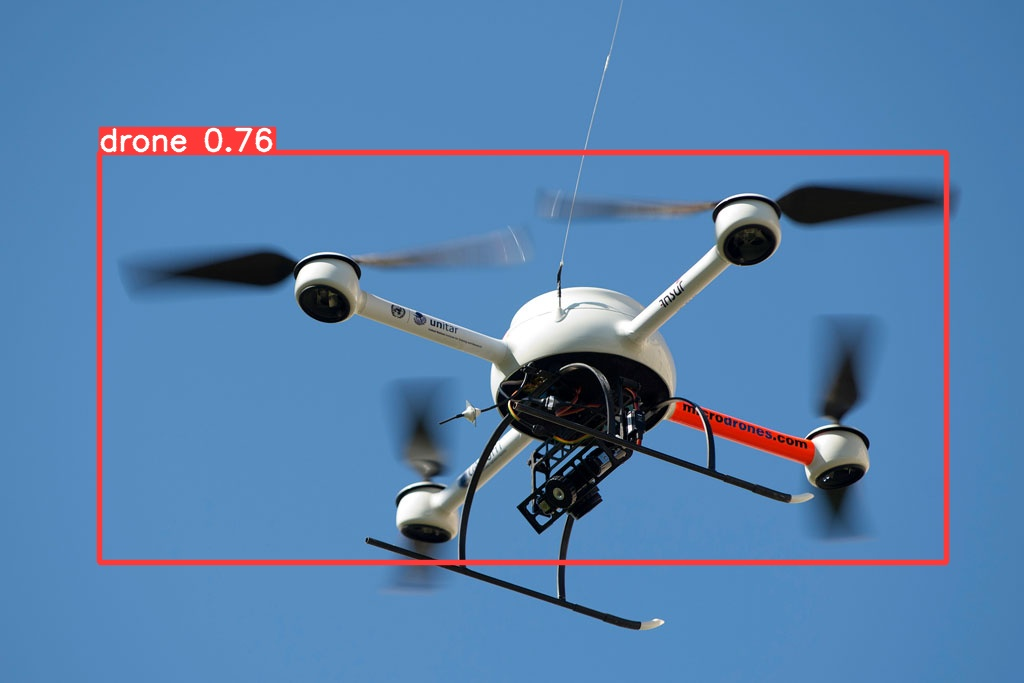

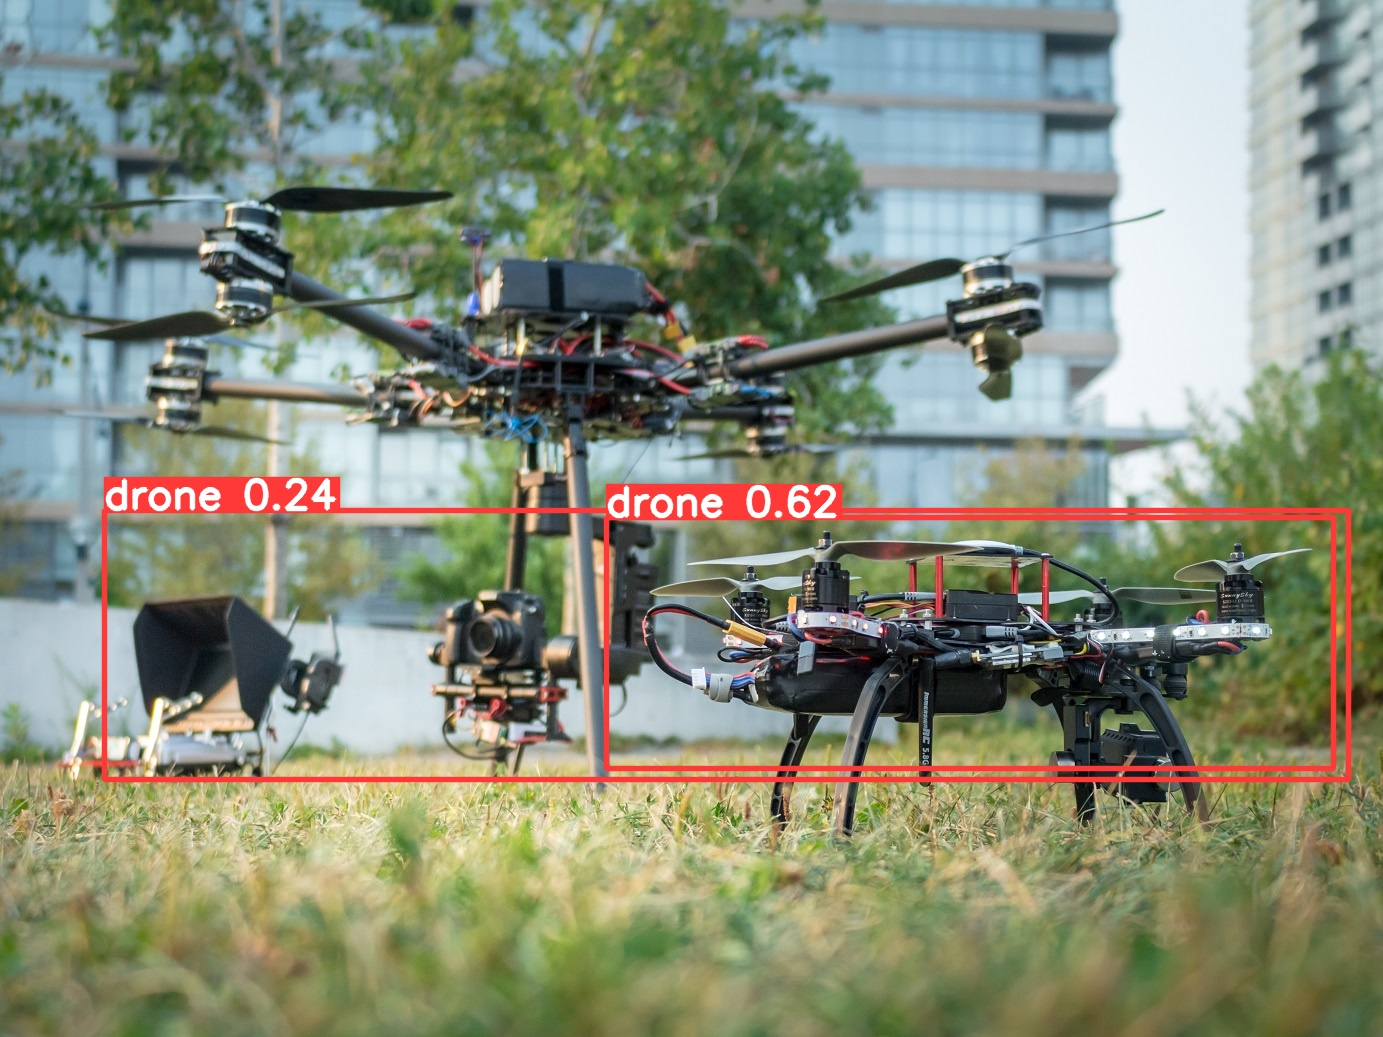